
## Entrenamiento de DensetNet121

c:\Users\Frank Prime\anaconda3\envs\tf210vit\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
300/300 [==============================] - 12s 23ms/step - loss: 0.2280 - accuracy: 0.9119 - val_loss: 0.1035 - val_accuracy: 0.9725
Epoch 2/300
300/300 [==============================] - 6s 19ms/step - loss: 0.0801 - accuracy: 0.9825 - val_loss: 0.0615 - val_accuracy: 0.9858
Epoch 3/300
300/300 [==============================] - 6s 19ms/step - loss: 0.0425 - accuracy: 0.9927 - val_loss: 0.0406 - val_accuracy: 0.9892
Epoch 4/300
300/300 [==============================] - 6s 19ms/step - loss: 0.0229 - accuracy: 0.9981 - val_loss: 0.0261 - val_accuracy: 0.9925
Epoch 5/300
300/300 [==============================] - 6s 19ms/step - loss: 0.0147 - accuracy: 0.9994 - val_loss: 0.0195 - val_accuracy: 0.9942
Epoch 6/300
300/300 [==============================] - 6s 19ms/step - loss: 0.0087 - accuracy: 0.9998 - val_loss: 0.0170 - val_accuracy: 0.9958
Epoch 7/300
300/300 [==============================] - 6s 19ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy

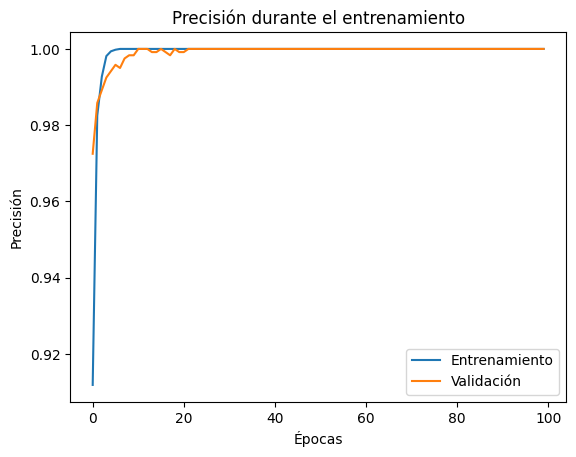

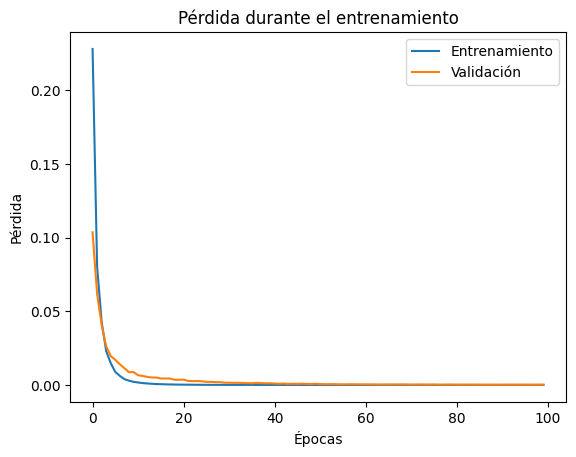

38/38 [==============================] - 2s 26ms/step


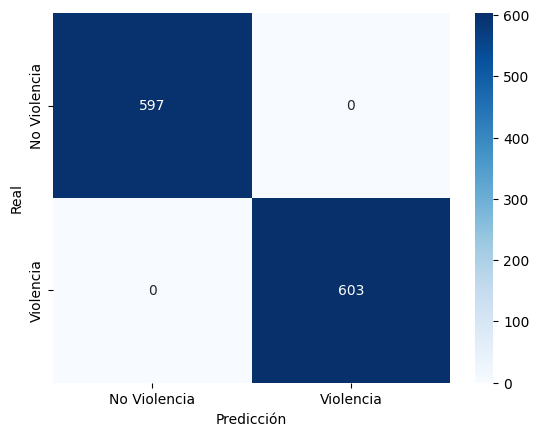

Modelo guardado como 'MobileNetV2'


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2  # <- CAMBIO: usar MobileNetV2

# Directorios de las imágenes
ruta_violentas = "../dataset/dataset1/violencia"
ruta_no_violentas = "../dataset/dataset1/no_violencia"

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    # Convertir las listas a arrays de numpy
    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes (escalarlas entre 0 y 1)
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# Crear el modelo MobileNetV2 preentrenado (solo este bloque cambia)
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # <- CAMBIO
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)  # Para clasificación con 2 clases
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Congelar las capas base para preentrenar

    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Función de entrenamiento
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=16):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[ 
            tf.keras.callbacks.EarlyStopping(patience=10),
            tf.keras.callbacks.ModelCheckpoint('modelo_mejorado_MobileNetV2.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')  # Para seguimiento con TensorBoard
        ]
    )
    return model_history

# Visualización de los resultados de entrenamiento
def plot_training_history(model_history):
    # Graficar precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Graficar pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

# Matriz de confusión
def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Violencia', 'Violencia'], yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Cargar las imágenes y etiquetas
imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)

# Dividir en conjunto de entrenamiento y validación (80% - 20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)

# Crear el modelo preentrenado
model = create_model()

# Entrenar el modelo
model_history = train_model(model, X_train, y_train, X_val, y_val)

# Graficar los resultados de entrenamiento y validación
plot_training_history(model_history)

# Graficar la matriz de confusión del conjunto de validación
plot_confusion_matrix(model, X_val, y_val)

# Guardar el modelo entrenado
model.save('Modelo_MobileNetV2.h5')  # (dejé el nombre exactamente igual como pediste)
print("Modelo guardado como 'MobileNetV2'")


138/138 [==============================] - 9s 39ms/step
Matriz de Confusión:
[[1508  692]
 [ 493 1707]]


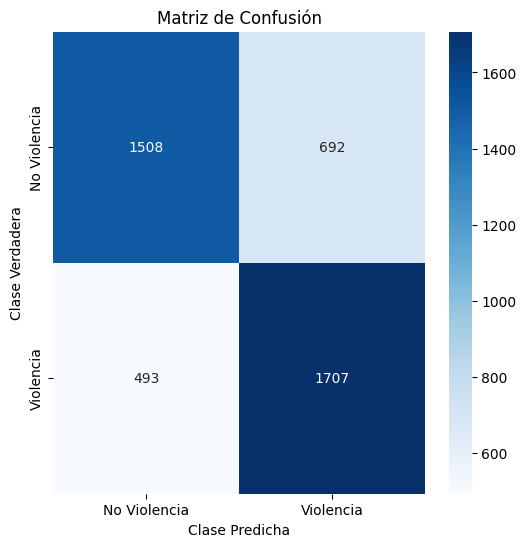

Precisión: 0.71
Recall: 0.78
F1-Score: 0.74


In [1]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directorios de las imágenes de prueba
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# Función para cargar las imágenes y etiquetas de prueba
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes = []
    etiquetas = []

    # Cargar imágenes de violencia
    for filename in os.listdir(ruta_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de no violencia
    for filename in os.listdir(ruta_no_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_no_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)

    return imagenes, etiquetas

# Cargar datos de prueba
X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)

# Cargar el modelo preentrenado (asegúrate de tener el archivo .h5 del modelo final)
modelo_cargado = load_model("modelo_mejorado_MobileNetV2.h5")

# Normalizar las imágenes de prueba
X_test = X_test / 255.0  # Normalizar las imágenes de prueba

# Realizar predicciones con el modelo cargado
predicciones = modelo_cargado.predict(X_test)

# Convertir las predicciones a las clases (1 para violencia, 0 para no violencia)
predicciones_clase = np.argmax(predicciones, axis=1)
y_test_clase = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test_clase, predicciones_clase)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(matriz_confusion)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violencia", "Violencia"], yticklabels=["No Violencia", "Violencia"])
plt.title("Matriz de Confusión")
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

# Calcular precisión, recall, f1-score (opcional)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_clase, predicciones_clase)
recall = recall_score(y_test_clase, predicciones_clase)
f1 = f1_score(y_test_clase, predicciones_clase)

print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Función para cargar las imágenes y etiquetas de prueba
def cargar_datos_test(ruta_violencia, ruta_no_violencia, img_size):
    imagenes = []
    etiquetas = []

    for filename in os.listdir(ruta_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_violencia, filename), target_size=img_size)
            imagen = img_to_array(imagen) / 255.0  # Normalizar
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    for filename in os.listdir(ruta_no_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_no_violencia, filename), target_size=img_size)
            imagen = img_to_array(imagen) / 255.0  # Normalizar
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    return np.array(imagenes), np.array(etiquetas)

# Función para seleccionar muestras según la categoría especificada
def seleccionar_muestras(predicciones, tipo):
    media_pred = np.mean(predicciones)
    std_pred = np.std(predicciones)

    if tipo == "safe":
        # Umbral fijo para 'safe': seleccionamos ejemplos con certeza alta (mayor a 0.9) o baja (menor a 0.1)
        umbral_inf = 0.0
        umbral_sup = 1.0
        indices_seleccionados = np.where((predicciones >= 0.9) | (predicciones <= 0.1))[0]
        print(f"\n--- Muestras {tipo} ---")
        print(f"Umbral fijo para {tipo}: ({umbral_inf}, {umbral_sup})")
        print("Explicación: Seleccionamos muestras con alta certeza de pertenecer a una clase (violencia o no violencia).")
    elif tipo == "border":
        # Umbral fijo para 'border': seleccionamos ejemplos con certeza media (entre 0.4 y 0.6)
        umbral_inf = 0.4
        umbral_sup = 0.6
        indices_seleccionados = np.where((predicciones >= umbral_inf) & (predicciones <= umbral_sup))[0]
        print(f"\n--- Muestras {tipo} ---")
        print(f"Umbral calculado para {tipo}: ({umbral_inf}, {umbral_sup})")
        print("Explicación: Seleccionamos muestras con certeza ambigua, donde el modelo no tiene una fuerte preferencia.")
    else:  # "average"
        umbral_inf = max(0.0, media_pred - std_pred)
        umbral_sup = min(1.0, media_pred + std_pred)
        indices_seleccionados = np.where((predicciones >= umbral_inf) & (predicciones <= umbral_sup))[0]
        print(f"\n--- Muestras {tipo} ---")
        print(f"Umbral calculado para {tipo}: ({umbral_inf}, {umbral_sup})")
        print("Explicación: Seleccionamos muestras con probabilidad promedio de pertenecer a una clase, dentro de una desviación estándar de la media.")

    print(f"Número de muestras {tipo} seleccionadas: {len(indices_seleccionados)}")
    
    return indices_seleccionados

# Cargar modelo
model_path = "modelo_mejorado_MobileNetV2.h5"
modelo = load_model(model_path)
img_size = (224, 224)

# Cargar datos de prueba
X_test, y_test = cargar_datos_test("../dataset/dataset22/violencia", "../dataset/dataset22/no_violencia", img_size)

# Realizar predicciones
predicciones = modelo.predict(X_test)[:, 0]

# Diccionario de carpetas
carpetas_modelos = {
    "safe": {"violencia": "../tipo3/safe/violencia", "no_violencia": "../tipo3/safe/no_violencia"},
    "border": {"violencia": "../tipo3/border/violencia", "no_violencia": "../tipo3/border/no_violencia"},
    "average": {"violencia": "../tipo3/average/violencia", "no_violencia": "../tipo3/average/no_violencia"}
}

# Procesar cada tipo de muestra
for tipo_muestra in ["safe", "border", "average"]:
    indices_seleccionados = seleccionar_muestras(predicciones, tipo=tipo_muestra)
    
    for i, indice in enumerate(indices_seleccionados):
        imagen = X_test[indice]
        etiqueta = y_test[indice]
        carpeta_destino = carpetas_modelos[tipo_muestra]["violencia" if etiqueta[0] == 1 else "no_violencia"]
        os.makedirs(carpeta_destino, exist_ok=True)
        ruta_destino = os.path.join(carpeta_destino, f"representativa_{i}.jpg")
        tf.keras.preprocessing.image.save_img(ruta_destino, imagen)

# Contar imágenes en cada carpeta
print("\n--- Resumen de imágenes guardadas ---")
for tipo_muestra, rutas in carpetas_modelos.items():
    for categoria, ruta in rutas.items():
        if os.path.exists(ruta):
            image_count = len([f for f in os.listdir(ruta) if f.endswith('.jpg')])
            print(f"{tipo_muestra} - {categoria}: {image_count} imágenes")
        else:
            print(f"{tipo_muestra} - {categoria}: La carpeta no existe.")

print("\nProceso completado. Las imágenes representativas han sido guardadas.")


175/175 [==============================] - 10s 39ms/step

--- Muestras safe ---
Umbral fijo para safe: (0.0, 1.0)
Explicación: Seleccionamos muestras con alta certeza de pertenecer a una clase (violencia o no violencia).
Número de muestras safe seleccionadas: 5074

--- Muestras border ---
Umbral calculado para border: (0.4, 0.6)
Explicación: Seleccionamos muestras con certeza ambigua, donde el modelo no tiene una fuerte preferencia.
Número de muestras border seleccionadas: 104

--- Muestras average ---
Umbral calculado para average: (0.0, 0.8931782841682434)
Explicación: Seleccionamos muestras con probabilidad promedio de pertenecer a una clase, dentro de una desviación estándar de la media.
Número de muestras average seleccionadas: 3490

--- Resumen de imágenes guardadas ---
safe - violencia: 2534 imágenes
safe - no_violencia: 2540 imágenes
border - violencia: 48 imágenes
border - no_violencia: 56 imágenes
average - violencia: 1693 imágenes
average - no_violencia: 1797 imágenes

Proce

# Average

Modelo cargado desde: modelo_mejorado_MobileNetV2.h5
Epoch 1/300
175/175 [==============================] - 8s 36ms/step - loss: 1.6588 - accuracy: 0.7249 - val_loss: 0.4733 - val_accuracy: 0.8739
Epoch 2/300
175/175 [==============================] - 6s 32ms/step - loss: 0.4141 - accuracy: 0.8743 - val_loss: 0.3629 - val_accuracy: 0.8854
Epoch 3/300
175/175 [==============================] - 5s 31ms/step - loss: 0.2101 - accuracy: 0.9269 - val_loss: 0.2078 - val_accuracy: 0.9241
Epoch 4/300
175/175 [==============================] - 5s 30ms/step - loss: 0.1095 - accuracy: 0.9624 - val_loss: 0.1580 - val_accuracy: 0.9456
Epoch 5/300
175/175 [==============================] - 5s 31ms/step - loss: 0.0680 - accuracy: 0.9774 - val_loss: 0.1408 - val_accuracy: 0.9527
Epoch 6/300
175/175 [==============================] - 5s 29ms/step - loss: 0.0419 - accuracy: 0.9889 - val_loss: 0.1410 - val_accuracy: 0.9527
Epoch 7/300
175/175 [==============================] - 5s 31ms/step - loss: 0.0285 

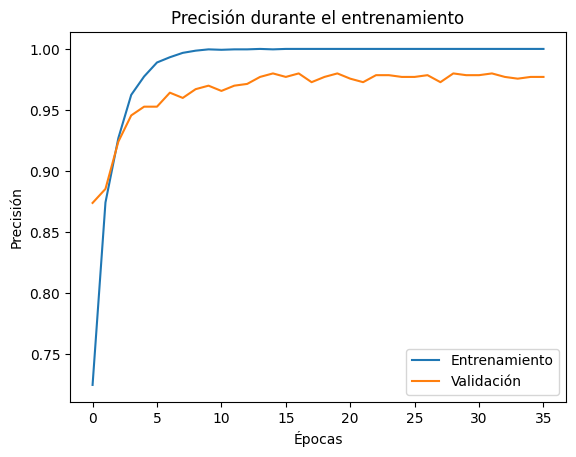

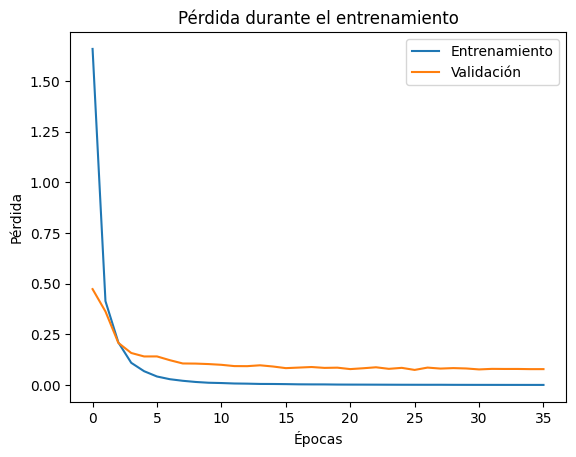

22/22 [==============================] - 1s 44ms/step - loss: 0.0781 - accuracy: 0.9771
Precisión en conjunto de validación: 0.9771
22/22 [==============================] - 2s 41ms/step


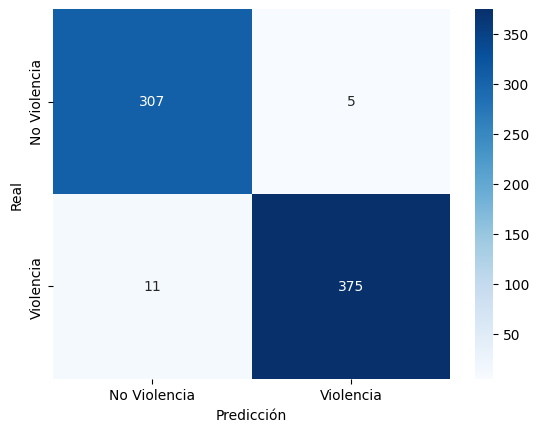

Modelo final guardado como 'Modelo_average.h5'.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# Función para cargar o crear el modelo
def load_or_create_model(model_path=None):
    if model_path and os.path.exists(model_path):
        # Cargar el modelo preentrenado desde el archivo .h5
        model = load_model(model_path)
        print("Modelo cargado desde:", model_path)
    else:
        # Crear un nuevo modelo base, si no hay modelo preentrenado
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False  # Congelar el modelo base
        
        # Crear un nuevo modelo con capas personalizadas
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(2, activation='softmax')  # Salida para 2 clases
        ])
        print("Nuevo modelo creado.")
        
    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Función para entrenar el modelo
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=16):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10),
            tf.keras.callbacks.ModelCheckpoint('modelo_finetuned_average.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]
    )
    return model_history

# Función para graficar los resultados de entrenamiento
def plot_training_history(model_history):
    # Graficar precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Graficar pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

# Función para graficar la matriz de confusión
def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Violencia', 'Violencia'], yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Función para evaluar el modelo
def evaluate_model(model, X_val, y_val):
    test_loss, test_acc = model.evaluate(X_val, y_val)
    print(f"Precisión en conjunto de validación: {test_acc:.4f}")
    return test_acc

# Función principal para ejecutar el flujo completo de trabajo
def run_pipeline(ruta_violentas, ruta_no_violentas, model_path=None, epochs=300, batch_size=2):
    # Cargar los datos
    imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)
    
    # Dividir en conjunto de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)
    
    # Cargar o crear el modelo
    model = load_or_create_model(model_path)

    # Entrenar el modelo
    model_history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    
    # Graficar resultados
    plot_training_history(model_history)
    
    # Evaluar y graficar la matriz de confusión
    evaluate_model(model, X_val, y_val)
    plot_confusion_matrix(model, X_val, y_val)
    
    # Guardar el modelo entrenado
    model.save('Modelo_average.h5')
    print("Modelo final guardado como 'Modelo_average.h5'.")

# Ejemplo de ejecución B
run_pipeline(
    ruta_violentas="../tipo3/average/violencia", 
    ruta_no_violentas="../tipo3/average/no_violencia", 
    model_path="modelo_mejorado_MobileNetV2.h5", 
    epochs=300, 
    batch_size=16
)


138/138 [==============================] - 9s 40ms/step
Matriz de Confusión:
[[2178   22]
 [ 742 1458]]


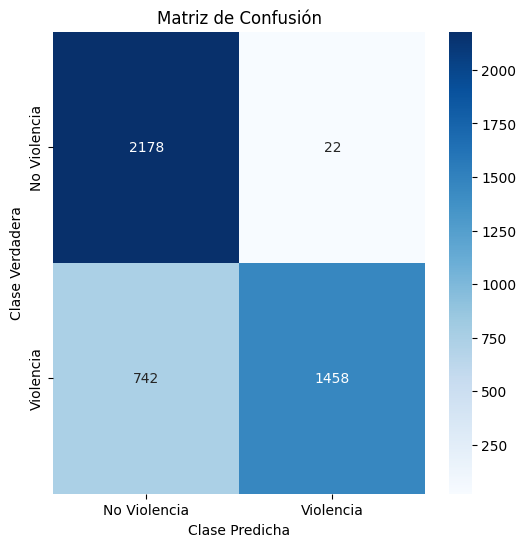

Precisión: 0.99
Recall: 0.66
F1-Score: 0.79


In [1]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directorios de las imágenes de prueba
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# Función para cargar las imágenes y etiquetas de prueba
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes = []
    etiquetas = []

    # Cargar imágenes de violencia
    for filename in os.listdir(ruta_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de no violencia
    for filename in os.listdir(ruta_no_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_no_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)

    return imagenes, etiquetas

# Cargar datos de prueba
X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)

# Cargar el modelo preentrenado (asegúrate de tener el archivo .h5 del modelo final)
modelo_cargado = load_model("modelo_finetuned_average.h5")

# Normalizar las imágenes de prueba
X_test = X_test / 255.0  # Normalizar las imágenes de prueba

# Realizar predicciones con el modelo cargado
predicciones = modelo_cargado.predict(X_test)

# Convertir las predicciones a las clases (1 para violencia, 0 para no violencia)
predicciones_clase = np.argmax(predicciones, axis=1)
y_test_clase = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test_clase, predicciones_clase)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(matriz_confusion)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violencia", "Violencia"], yticklabels=["No Violencia", "Violencia"])
plt.title("Matriz de Confusión")
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

# Calcular precisión, recall, f1-score (opcional)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_clase, predicciones_clase)
recall = recall_score(y_test_clase, predicciones_clase)
f1 = f1_score(y_test_clase, predicciones_clase)

print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Border

Modelo cargado desde: modelo_mejorado_MobileNetV2.h5
Epoch 1/1000
6/6 [==============================] - 3s 281ms/step - loss: 1.9134 - accuracy: 0.6988 - val_loss: 1.2995 - val_accuracy: 0.5714
Epoch 2/1000
6/6 [==============================] - 0s 49ms/step - loss: 1.0898 - accuracy: 0.6867 - val_loss: 2.0622 - val_accuracy: 0.4762
Epoch 3/1000
6/6 [==============================] - 0s 36ms/step - loss: 0.8934 - accuracy: 0.8193 - val_loss: 1.8730 - val_accuracy: 0.6190
Epoch 4/1000
6/6 [==============================] - 1s 107ms/step - loss: 0.3166 - accuracy: 0.9157 - val_loss: 0.6489 - val_accuracy: 0.7619
Epoch 5/1000
6/6 [==============================] - 0s 38ms/step - loss: 0.4234 - accuracy: 0.8795 - val_loss: 0.7824 - val_accuracy: 0.7143
Epoch 6/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.1905 - accuracy: 0.9639 - val_loss: 1.7411 - val_accuracy: 0.6667
Epoch 7/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0910 - accuracy: 0.9759 

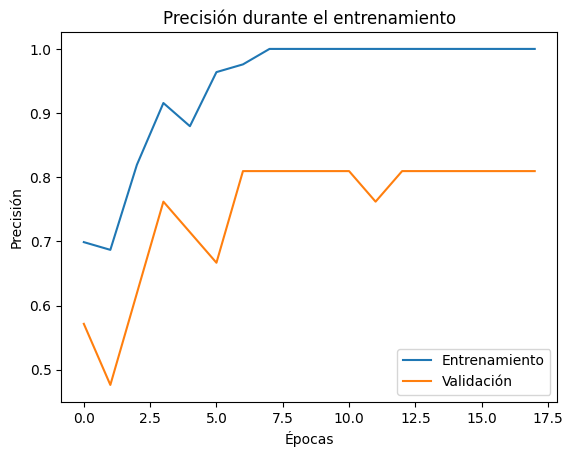

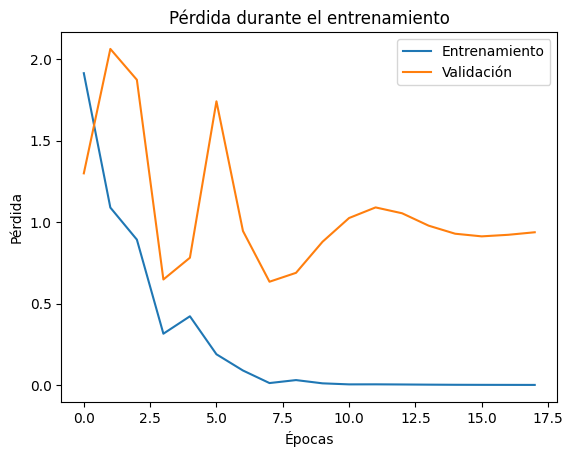

1/1 [==============================] - 0s 53ms/step - loss: 0.9388 - accuracy: 0.8095
Precisión en conjunto de validación: 0.8095
1/1 [==============================] - 1s 765ms/step


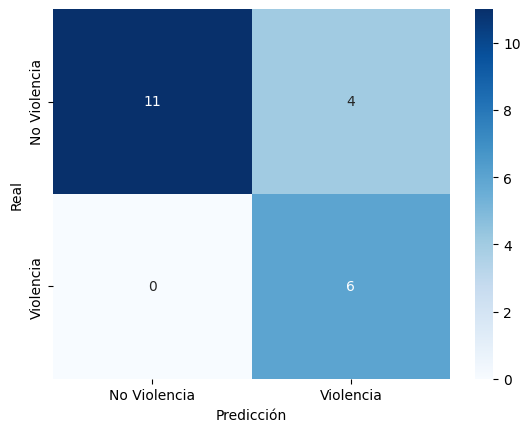

Modelo final guardado como 'Modelo_border.h5'.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# Función para cargar o crear el modelo
def load_or_create_model(model_path=None):
    if model_path and os.path.exists(model_path):
        # Cargar el modelo preentrenado desde el archivo .h5
        model = load_model(model_path)
        print("Modelo cargado desde:", model_path)
    else:
        # Crear un nuevo modelo base, si no hay modelo preentrenado
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False  # Congelar el modelo base
        
        # Crear un nuevo modelo con capas personalizadas
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(2, activation='softmax')  # Salida para 2 clases
        ])
        print("Nuevo modelo creado.")
        
    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Función para entrenar el modelo
def train_model(model, X_train, y_train, X_val, y_val, epochs=1000, batch_size=16):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10),
            tf.keras.callbacks.ModelCheckpoint('modelo_finetuned_border.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]
    )
    return model_history

# Función para graficar los resultados de entrenamiento
def plot_training_history(model_history):
    # Graficar precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Graficar pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

# Función para graficar la matriz de confusión
def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Violencia', 'Violencia'], yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Función para evaluar el modelo
def evaluate_model(model, X_val, y_val):
    test_loss, test_acc = model.evaluate(X_val, y_val)
    print(f"Precisión en conjunto de validación: {test_acc:.4f}")
    return test_acc

# Función principal para ejecutar el flujo completo de trabajo
def run_pipeline(ruta_violentas, ruta_no_violentas, model_path=None, epochs=1000, batch_size=32):
    # Cargar los datos
    imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)
    
    # Dividir en conjunto de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)
    
    # Cargar o crear el modelo
    model = load_or_create_model(model_path)

    # Entrenar el modelo
    model_history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    
    # Graficar resultados
    plot_training_history(model_history)
    
    # Evaluar y graficar la matriz de confusión
    evaluate_model(model, X_val, y_val)
    plot_confusion_matrix(model, X_val, y_val)
    
    # Guardar el modelo entrenado
    model.save('Modelo_border.h5')
    print("Modelo final guardado como 'Modelo_border.h5'.")

# Ejemplo de ejecución B
run_pipeline(
    ruta_violentas="../tipo3/border/violencia", 
    ruta_no_violentas="../tipo3/border/no_violencia", 
    model_path="modelo_mejorado_MobileNetV2.h5", 
    epochs=1000, 
    batch_size=16
)


138/138 [==============================] - 6s 40ms/step
Matriz de Confusión:
[[1659  541]
 [ 487 1713]]


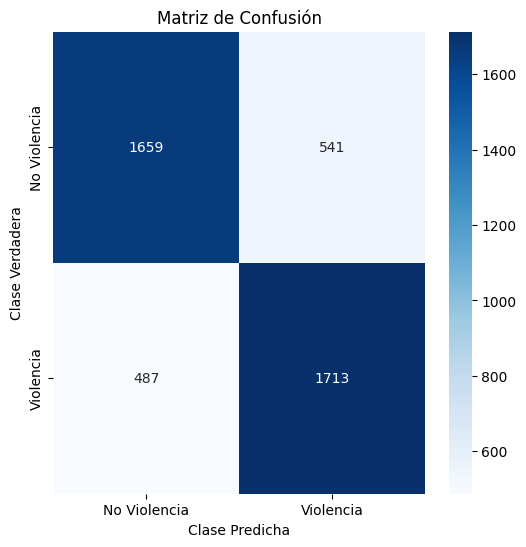

Precisión: 0.76
Recall: 0.78
F1-Score: 0.77


In [3]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directorios de las imágenes de prueba
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# Función para cargar las imágenes y etiquetas de prueba
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes = []
    etiquetas = []

    # Cargar imágenes de violencia
    for filename in os.listdir(ruta_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de no violencia
    for filename in os.listdir(ruta_no_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_no_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)

    return imagenes, etiquetas

# Cargar datos de prueba
X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)

# Cargar el modelo preentrenado (asegúrate de tener el archivo .h5 del modelo final)
modelo_cargado = load_model("modelo_finetuned_border.h5")

# Normalizar las imágenes de prueba
X_test = X_test / 255.0  # Normalizar las imágenes de prueba

# Realizar predicciones con el modelo cargado
predicciones = modelo_cargado.predict(X_test)

# Convertir las predicciones a las clases (1 para violencia, 0 para no violencia)
predicciones_clase = np.argmax(predicciones, axis=1)
y_test_clase = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test_clase, predicciones_clase)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(matriz_confusion)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violencia", "Violencia"], yticklabels=["No Violencia", "Violencia"])
plt.title("Matriz de Confusión")
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

# Calcular precisión, recall, f1-score (opcional)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_clase, predicciones_clase)
recall = recall_score(y_test_clase, predicciones_clase)
f1 = f1_score(y_test_clase, predicciones_clase)

print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Safe

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Función para cargar las imágenes y sus etiquetas
def load_images_and_labels(ruta_violentas, ruta_no_violentas):
    imagenes = []
    etiquetas = []
    
    # Cargar imágenes de la carpeta de violencia
    for filename in os.listdir(ruta_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de la carpeta de no violencia
    for filename in os.listdir(ruta_no_violentas):
        if filename.endswith(".jpg"):
            imagen = tf.keras.preprocessing.image.load_img(
                os.path.join(ruta_no_violentas, filename), target_size=(224, 224)
            )
            imagen = tf.keras.preprocessing.image.img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    
    # Normalizar las imágenes
    imagenes = imagenes / 255.0
    
    return imagenes, etiquetas

# Función para cargar o crear el modelo
def load_or_create_model(model_path=None):
    if model_path and os.path.exists(model_path):
        # Cargar el modelo preentrenado desde el archivo .h5
        model = load_model(model_path)
        print("Modelo cargado desde:", model_path)
    else:
        # Crear un nuevo modelo base, si no hay modelo preentrenado
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False  # Congelar el modelo base
        
        # Crear un nuevo modelo con capas personalizadas
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(2, activation='softmax')  # Salida para 2 clases
        ])
        print("Nuevo modelo creado.")
        
    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Función para entrenar el modelo
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, batch_size=16):
    model_history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=15),
            tf.keras.callbacks.ModelCheckpoint('modelo_finetuned_safe.h5', save_best_only=True),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]
    )
    return model_history

# Función para graficar los resultados de entrenamiento
def plot_training_history(model_history):
    # Graficar precisión
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

    # Graficar pérdida
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(['Entrenamiento', 'Validación'])
    plt.show()

# Función para graficar la matriz de confusión
def plot_confusion_matrix(model, X_val, y_val):
    preds = model.predict(X_val)
    predicted_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_val, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Violencia', 'Violencia'], yticklabels=['No Violencia', 'Violencia'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Función para evaluar el modelo
def evaluate_model(model, X_val, y_val):
    test_loss, test_acc = model.evaluate(X_val, y_val)
    print(f"Precisión en conjunto de validación: {test_acc:.4f}")
    return test_acc

# Función principal para ejecutar el flujo completo de trabajo
def run_pipeline(ruta_violentas, ruta_no_violentas, model_path=None, epochs=300, batch_size=2):
    # Cargar los datos
    imagenes, etiquetas = load_images_and_labels(ruta_violentas, ruta_no_violentas)
    
    # Dividir en conjunto de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=2)
    
    # Cargar o crear el modelo
    model = load_or_create_model(model_path)

    # Entrenar el modelo
    model_history = train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size)
    
    # Graficar resultados
    plot_training_history(model_history)
    
    # Evaluar y graficar la matriz de confusión
    evaluate_model(model, X_val, y_val)
    plot_confusion_matrix(model, X_val, y_val)
    
    # Guardar el modelo entrenado
    model.save('Modelo_safe.h5')
    print("Modelo final guardado como 'Modelo_safe.h5'.")

# Ejemplo de ejecución B
run_pipeline(
    ruta_violentas="../tipo3/safe/violencia", 
    ruta_no_violentas="../tipo3/safe/no_violencia", 
    model_path="modelo_mejorado_MobileNetV2.h5", 
    epochs=300, 
    batch_size=16
)


Modelo cargado desde: modelo_mejorado_MobileNetV2.h5
Epoch 1/300
254/254 [==============================] - 16s 40ms/step - loss: 1.8381 - accuracy: 0.7275 - val_loss: 0.4835 - val_accuracy: 0.8611
Epoch 2/300
254/254 [==============================] - 9s 34ms/step - loss: 0.3307 - accuracy: 0.8948 - val_loss: 0.2493 - val_accuracy: 0.9094
Epoch 3/300
254/254 [==============================] - 9s 35ms/step - loss: 0.1693 - accuracy: 0.9387 - val_loss: 0.1816 - val_accuracy: 0.9379
Epoch 4/300
254/254 [==============================] - 9s 35ms/step - loss: 0.0976 - accuracy: 0.9662 - val_loss: 0.1488 - val_accuracy: 0.9488
Epoch 5/300
254/254 [==============================] - 8s 33ms/step - loss: 0.0602 - accuracy: 0.9845 - val_loss: 0.1547 - val_accuracy: 0.9507
Epoch 6/300
254/254 [==============================] - 9s 36ms/step - loss: 0.0383 - accuracy: 0.9929 - val_loss: 0.1151 - val_accuracy: 0.9645
Epoch 7/300
254/254 [==============================] - 8s 32ms/step - loss: 0.0265

138/138 [==============================] - 9s 26ms/step
Matriz de Confusión:
[[2180   20]
 [ 712 1488]]


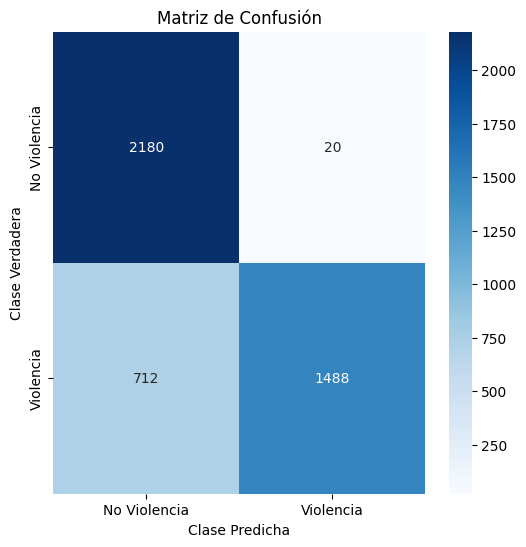

Precisión: 0.99
Recall: 0.68
F1-Score: 0.80


In [1]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directorios de las imágenes de prueba
ruta_test_violencia = "../test2/violencia"
ruta_test_no_violencia = "../test2/no_violencia"

# Función para cargar las imágenes y etiquetas de prueba
def cargar_datos_test(ruta_violencia, ruta_no_violencia):
    imagenes = []
    etiquetas = []

    # Cargar imágenes de violencia
    for filename in os.listdir(ruta_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([1, 0])  # Etiqueta [1, 0] para violencia

    # Cargar imágenes de no violencia
    for filename in os.listdir(ruta_no_violencia):
        if filename.endswith(".jpg"):
            imagen = load_img(os.path.join(ruta_no_violencia, filename), target_size=(224, 224))
            imagen = img_to_array(imagen)
            imagenes.append(imagen)
            etiquetas.append([0, 1])  # Etiqueta [0, 1] para no violencia

    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)

    return imagenes, etiquetas

# Cargar datos de prueba
X_test, y_test = cargar_datos_test(ruta_test_violencia, ruta_test_no_violencia)

# Cargar el modelo preentrenado (asegúrate de tener el archivo .h5 del modelo final)
modelo_cargado = load_model("modelo_finetuned_safe.h5")

# Normalizar las imágenes de prueba
X_test = X_test / 255.0  # Normalizar las imágenes de prueba

# Realizar predicciones con el modelo cargado
predicciones = modelo_cargado.predict(X_test)

# Convertir las predicciones a las clases (1 para violencia, 0 para no violencia)
predicciones_clase = np.argmax(predicciones, axis=1)
y_test_clase = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test_clase, predicciones_clase)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(matriz_confusion)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violencia", "Violencia"], yticklabels=["No Violencia", "Violencia"])
plt.title("Matriz de Confusión")
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

# Calcular precisión, recall, f1-score (opcional)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_clase, predicciones_clase)
recall = recall_score(y_test_clase, predicciones_clase)
f1 = f1_score(y_test_clase, predicciones_clase)

print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")